## PyTorch关于GAN部分

关于GAN的理论知识我在此就不细讲了，大致叙述一下，GAN由两个神经网络构成，一个是判别器，一个是生成器。

生成器负责生成样本，而判别器负责判断出哪个样本是由生成器生成的样本，哪个是真实样本，两者之间是一个对抗的关系（或者说竞争关系），即正如其名————生成式对抗网络。

这是一个十分巧妙的架构设计，不仅是因为它利用对抗思想来驱动进步，也是因为它不需要定义具体的规则来描述要编码到损失函数中的真实图像（即不需要定义一个输入它的具体目标输出）。机器学习的历史也告诉我们，我们并不擅长定义这样的规则。相反，我们让GAN自己来学习真正的图像应该是什么样子的。

### GAN的训练

关于GAN的训练，我们不应该先将判别器或者生成器之间的任何一方训练至完美或者将近完美，再去训练另一方。我们应该使它们两个能够一起学习，任何一方都不应该超过另一方太多。

以先训练判别器最优为例，此时的判别器是一个很完美的判别器，但此时的生成器确是一个技术十分生疏的造假者，不论生成器如何生成样本，判别器都能够十分有效的将其区分出来，这样就让生成器没有足够的动力，或者说没有一个明确的方向，它应该如何生成样本才能够使它生成的样本更加的真实，说白了就是“不行了，我做不出来，摆烂了”差不多这感觉，数学语言说就是判别器不能够提供足够的梯度来进行学习，即梯度消失问题。


#### 1. 1010格式规律

在进行MNIST为例的GAN学习前，我们先以一个简单的例子来理清整个GAN的基本代码框架。

此时的真实数据集是一个“1010”由四个数字组成的数字串 + 一点随机扰动

In [1]:
# 导入库

import torch
import torch.nn as nn
import pandas
import matplotlib.pyplot as plt
import random
import numpy

In [2]:
# 真实数据源

def generate_real():
    real_data = torch.FloatTensor([
        random.uniform(0.8,1.0),
        random.uniform(0.0,0.2),
        random.uniform(0.8,1.0),
        random.uniform(0.0,0.2)])
    return real_data

In [3]:
# 判别器的构造

class Discriminator(nn.Module):

    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )

        # 创建损失函数
        self.loss_function = nn.MSELoss()

        # 创建优化器，使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.forward(inputs)

        # 计算损失值
        loss = self.loss_function(outputs, targets)

        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))


In [4]:
def generate_random(size=4):
    random_data = torch.rand(size)
    return random_data

In [5]:
D = Discriminator()

for i in range(10000):
    # 真实数据
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # 随机数据
    D.train(generate_random(), torch.FloatTensor([0.0]))


KeyboardInterrupt: 

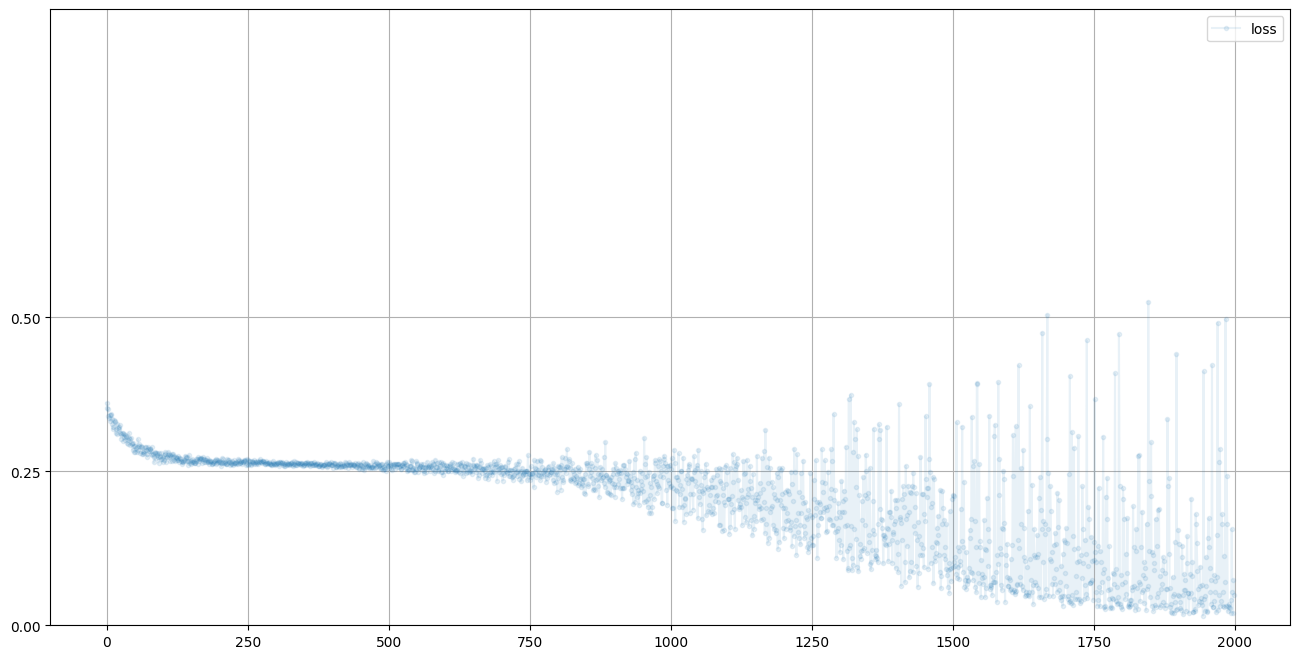

In [6]:
D.plot_progress()

In [7]:
print(D.forward(generate_random()).item())
print(D.forward(generate_real()).item())

0.1784489005804062
0.6604726314544678


**生成器的构建**

由于我们不希望生成器和判别器中的任何一个领先另一个太多，所以我们尝试从复制判别器的构造入手来设计生成器。

跟所有的神经网络一样，生成器也需要输入。生成器的输入应该是什么呢? 我们先从最简单的方案做起，即输入一个常数值。我们知道，太大的值会增加训练的难度，而标准化数据会有所帮助。我们暂时设输入值为0.5，如果遇到问题，可以回来修改。

注意：这里的损失函数是根据判别器的输出计算的

In [6]:
# 构建生成器

class Generator(nn.Module):

    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(1,3),
            nn.Sigmoid(),
            nn.Linear(3,4),
            nn.Sigmoid()
        )

        # 创建优化器，使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入判别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)
        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))


有Python使用经验的读者可能会问，将整个复杂的discriminator对象传递给生成器的train()函数有没有问题？其实不必担心，因为Python没有传递单独的副本，它传递的只是对同一对象的引用。这样不仅高效，而且允许我们在生成器中对该对象进行更改，并可以反向传递误差梯度。

我们还删除了生成器里train()函数中的计数打印语句，改为在鉴别器的train()中打印。这样可以通过真实的训练数据更准确地反映训练进度。

In [9]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5393, 0.6591, 0.6271, 0.3574], grad_fn=<SigmoidBackward0>)

**训练GAN**

对于生成器输出，detach()的作用是将其从计算图中分离出来。通常，对判别器损失直接调用backwards()函数会计算整个计算图路径的所有误差梯度。这个路径从判别器损失开始，经过判别器本身，最后返回生成器。由于我们只希望训练判别器，因此不需要计算生成器的梯度。生成器的detach()可以在该点切断计算图。

为什么要这么做呢？ 即使不这样做，照常计算生成器中的梯度，应该也不会有什么坏处吧? 的确，在我们这个简单的网络中，切断计算图的好处不是很明显。但是，对于更大的网络，这么做可以明显地节省计算成本。

In [10]:
%%time
# 创建判别器和生成器

D = Discriminator()
G = Generator()

image_list = []   # 查看生成器输出的演变过程

# 训练判别器和生成器
for i in range(10000):
    # 用真实样本训练判别器
    D.train(generate_real(), torch.FloatTensor([1.0]))

    # 用生成样本训练判别器
    # 使用detach()以避免计算生成器G中的梯度
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

    # 训练生成器
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

    # 每训练1 000次记录图像
    if (i % 1000 == 0):
        image_list.append( G.forward(torch.FloatTensor([0.5])).
        detach().numpy() )

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
CPU times: total: 26.7 s
Wall time: 28.1 s


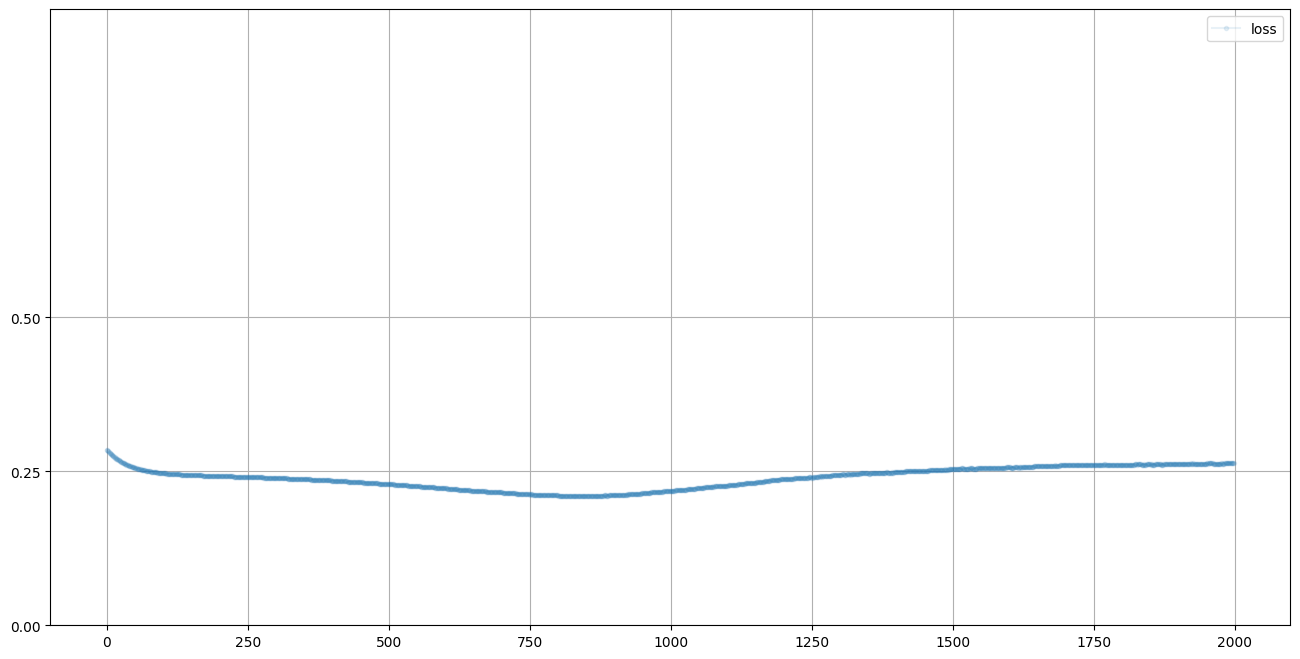

In [11]:
D.plot_progress()

这条曲线十分有意思，在此之前，我们认为，随着神经网络在任务中的表现越来越好，我们的训练损失值将接近 $0$ 。然而，这里的损失值保持在 $0.25$ 左右。这个数字有什么特别的含义吗?

当判别器不擅长从伪造数据中识别真实数据时，它就无法确定输出 $0.0$ 还是 $1.0$ ，索性就输出 $0.5$ 。因为我们使用了均方误差，所以损失值的结果是 $0.5$ 的平方，也就是 $0.25$ 。

在这里，随着训练的进行，损失值略有下降，但幅度并不大。这说明判别网络有了一些进步。在训练的后期，损失值回升到 $0.25$ 。这是一个好现象，说明生成器已经学会生成1010格式的数据，从而使鉴别器无法区分。

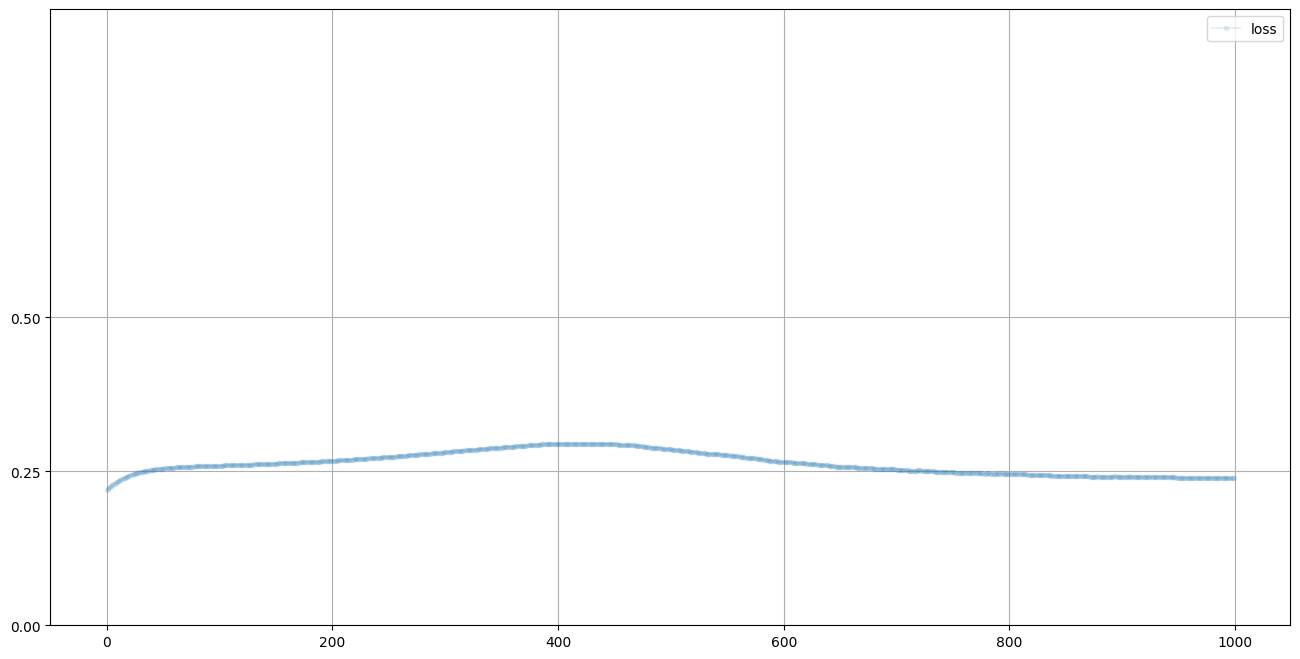

In [12]:
G.plot_progress()

刚开始，判别器在区分真假模式时并不是很确定。在训练进行到一半时，损失值略有增加，这表明生成器在进步，开始可以骗过判别器了。在训练后期，我们看到生成器和判别器达到平衡。

通过观察训练过程中的损失值变化来了解训练的进展是一个好习惯。从上面的两个图中，我们看到训练没有完全失败，也没有看到损失值的剧烈振荡，那是学习不稳定的一种表现。

In [13]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.8961, 0.0687, 0.9398, 0.0411], grad_fn=<SigmoidBackward0>)

查看1010格式规律在训练过程中是如何演变的

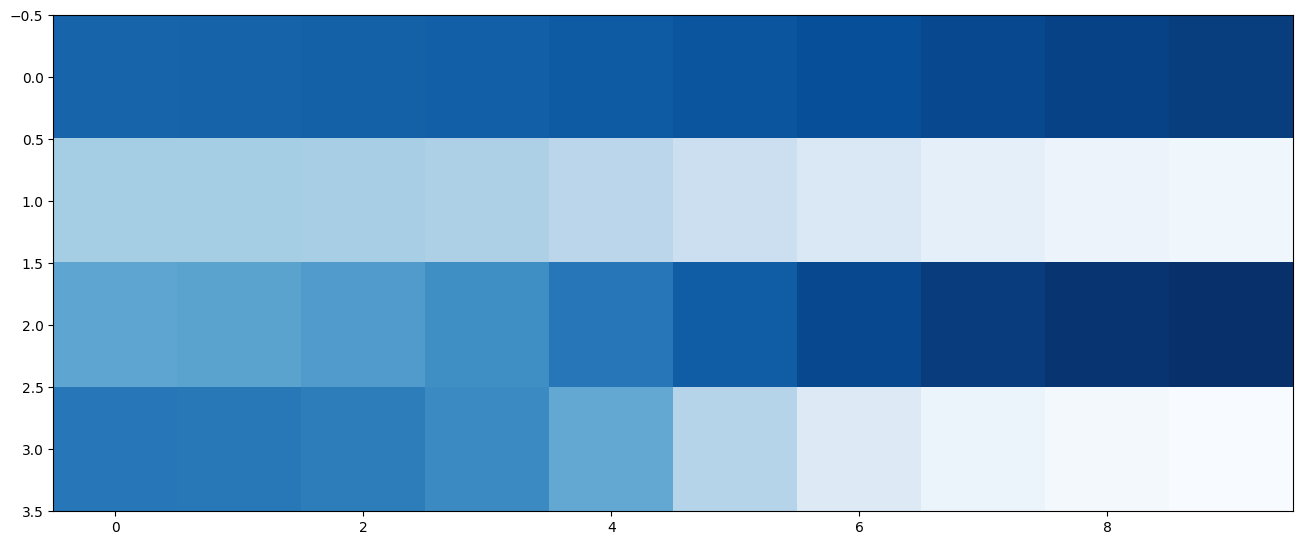

In [14]:
# image_list = []
# # 每训练1 000次记录图像
# if (i % 1000 == 0):
#     image_list.append( G.forward(torch.FloatTensor([0.5])).
#     detach().numpy() )

plt.figure(figsize = (16,8))
plt.imshow(numpy.array(image_list).T, interpolation='none',
cmap='Blues')

上图非常清楚地显示了生成器是如何随着训练时间而进步的。最初，生成器输出的规律相当模糊。在训练进行到一半时，生成器可以生成有点符合1010格式规律的图像了。在余下的训练过程中，该输出规律变得越来越清晰。

#### 2. 生成手写数字

In [8]:
# 导入所需库
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas, numpy, random
import matplotlib.pyplot as plt

In [10]:
# 创建一个MnistDataset类
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # 目标图像（标签）
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0 # type: ignore

        # 图像数据，取值范围为0~255,标准化为0~1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].to_numpy()) / 255.0

        # 返回标签、图像数据张量以及目标张量
        return label,image_values,target

    def plot_image(self,index):
        arr = self.data_df.iloc[index,1:].to_numpy().reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='gray')

In [11]:
mnist_dataset = MnistDataset('data/mnist_train.csv')
# mnist_dataset.plot_image(9)

In [10]:
# 判别器的构造

class Discriminator(nn.Module):

    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # 创建损失函数
        self.loss_function = nn.MSELoss()

        # 创建优化器，使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.forward(inputs)

        # 计算损失值
        loss = self.loss_function(outputs, targets)

        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))


In [19]:
%%time
D = Discriminator()
for label, image_data_tensor, target_tensor in mnist_dataset:
    # 真实数据
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # 生成数据
    D.train(generate_random(784), torch.FloatTensor([0.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

In [20]:
# 测试判别器
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
    print(D.forward(image_data_tensor).item())

for i in range(4):
    print(D.forward(generate_random(784)).item())

0.9970707893371582
0.9964600205421448
0.9951381087303162
0.9963511228561401
0.006355594843626022
0.006444041151553392
0.00667932815849781
0.005945757031440735


In [11]:
# 构建生成器

class Generator(nn.Module):

    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(1,200),
            nn.Sigmoid(),
            nn.Linear(200,784),
            nn.Sigmoid()
        )

        # 创建优化器，使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入判别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)
        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))


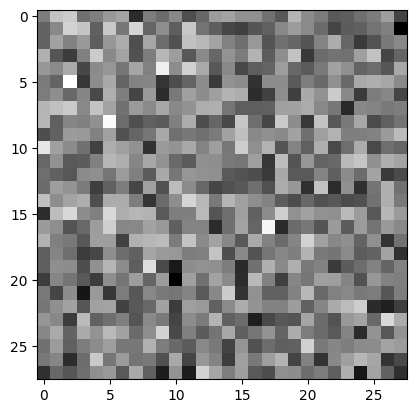

In [22]:
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='gray')

In [23]:
# 创建鉴别器和生成器
D = Discriminator()
G = Generator()
# 训练鉴别器和生成器
for label, image_data_tensor, target_tensor in mnist_dataset:
    # 使用真实数据训练鉴别器
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # 用生成样本训练鉴别器
    # 使用detach()以避免计算生成器G中的梯度
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    # 训练生成器
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

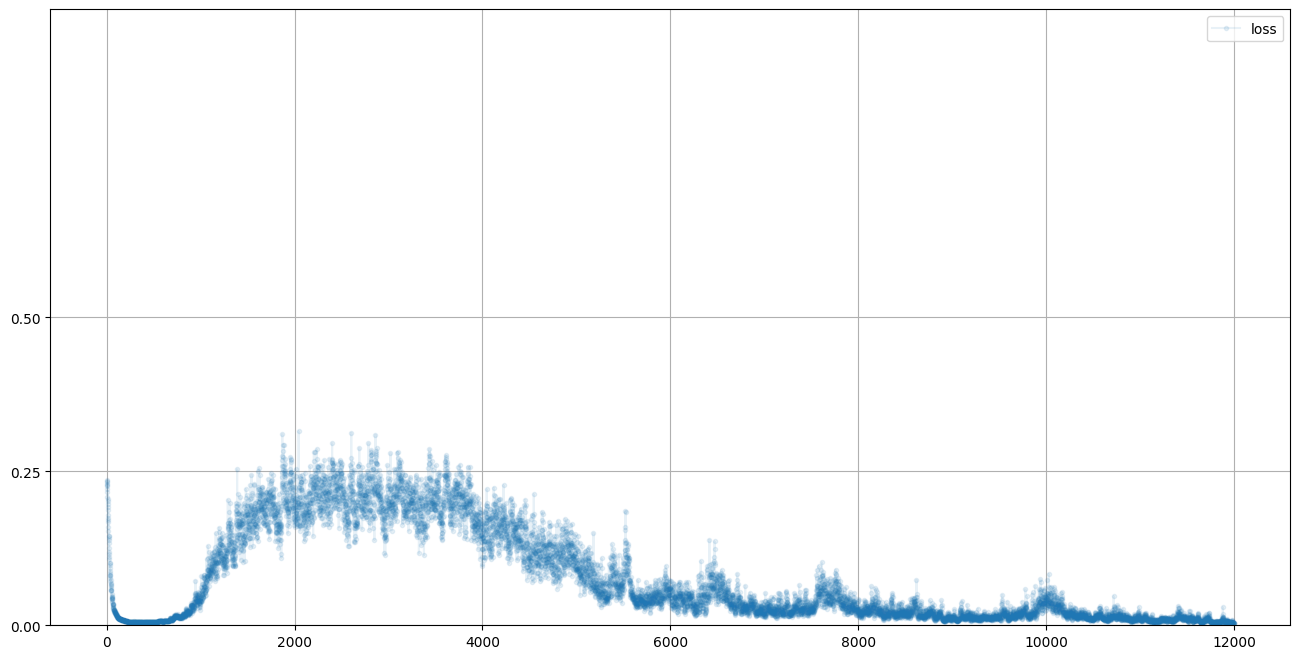

In [24]:
D.plot_progress()

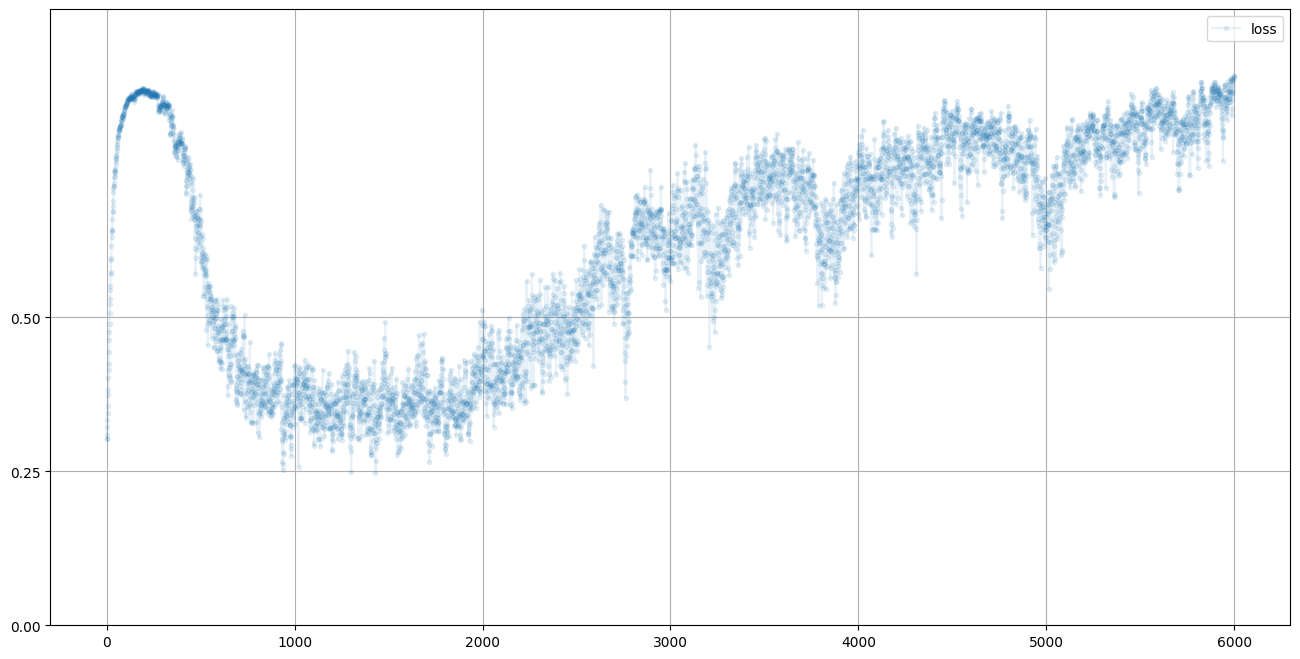

In [25]:
G.plot_progress()

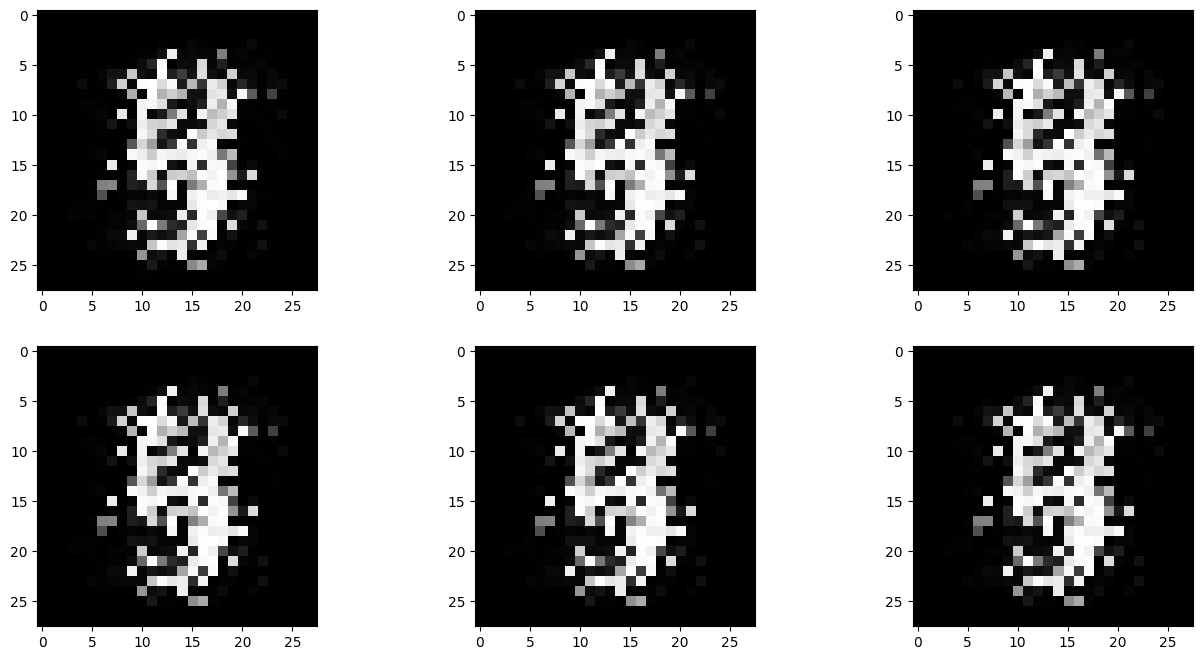

In [27]:
# 在3列2行的网格中生成图像
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='gray')
        pass
    pass

首先注意到，生成的图像不是随机噪声，而是有某种形状。图像中间有较暗的区域，与真实的手写数字图像很像。即使图中显示的数字并不完美，这仍是一个不错的开端。我们用相对简单的代码实现了一个重要的里程碑。要记住，生成器并没有直接看过MNIST数据集中的图像，但是它已经学会了创建类似的图像。这些图像不是随机噪声，而是几乎可被识别的手写数字。

上述我们看到的现象，在GAN训练中非常常见，我们称它为**模式崩溃**（mode collapse）。在MNIST的案例中，我们希望生成器能够创建代表所有10个数字的图像。当模式崩溃发生时，生成器只能生成10个数字中的一个或部分数字，无法达到我们的要求。

模式崩溃的解释之一是，在鉴别器学会向生成器提供良好的反馈之前，生成器率先发现一个一直被判定为真实图像的输出。为此，有人提出一些解决方案，比如更频繁地训练鉴别器。但在实践中，这样做往往效果不佳。这就表明，解决问题的关键不仅在于训练的数量，也在于训练的质量。

在我们的例子中，生成器的损失值不断增加，表明它的学习没有进展。可能的原因是，鉴别器没有很好地为它提供有效的反馈。这再次表明，训练质量是一个挑战。

**GAN训练的改良**

In [12]:
# 判别器的构造

class Discriminator(nn.Module):

    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # 创建损失函数
        # self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss()

        # 创建优化器，使用随机梯度下降
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.forward(inputs)

        # 计算损失值
        loss = self.loss_function(outputs, targets)

        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))


In [14]:
# 构建生成器

class Generator(nn.Module):

    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(1,200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200,784),
            nn.Sigmoid()
        )

        # 创建优化器，使用随机梯度下降
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入判别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)
        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))


In [15]:
# 创建鉴别器和生成器
D = Discriminator()
G = Generator()
# 训练鉴别器和生成器
for label, image_data_tensor, target_tensor in mnist_dataset:
    # 使用真实数据训练鉴别器
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # 用生成样本训练鉴别器
    # 使用detach()以避免计算生成器G中的梯度
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    # 训练生成器
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

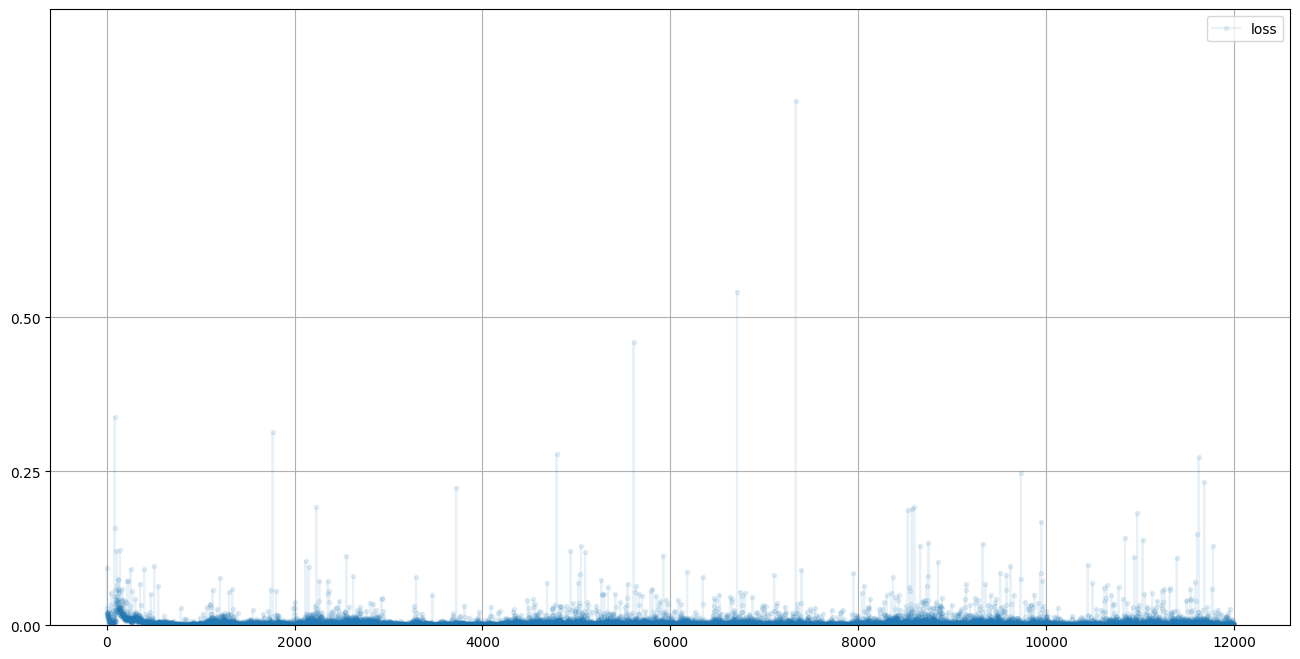

In [16]:
D.plot_progress()

<Axes: >

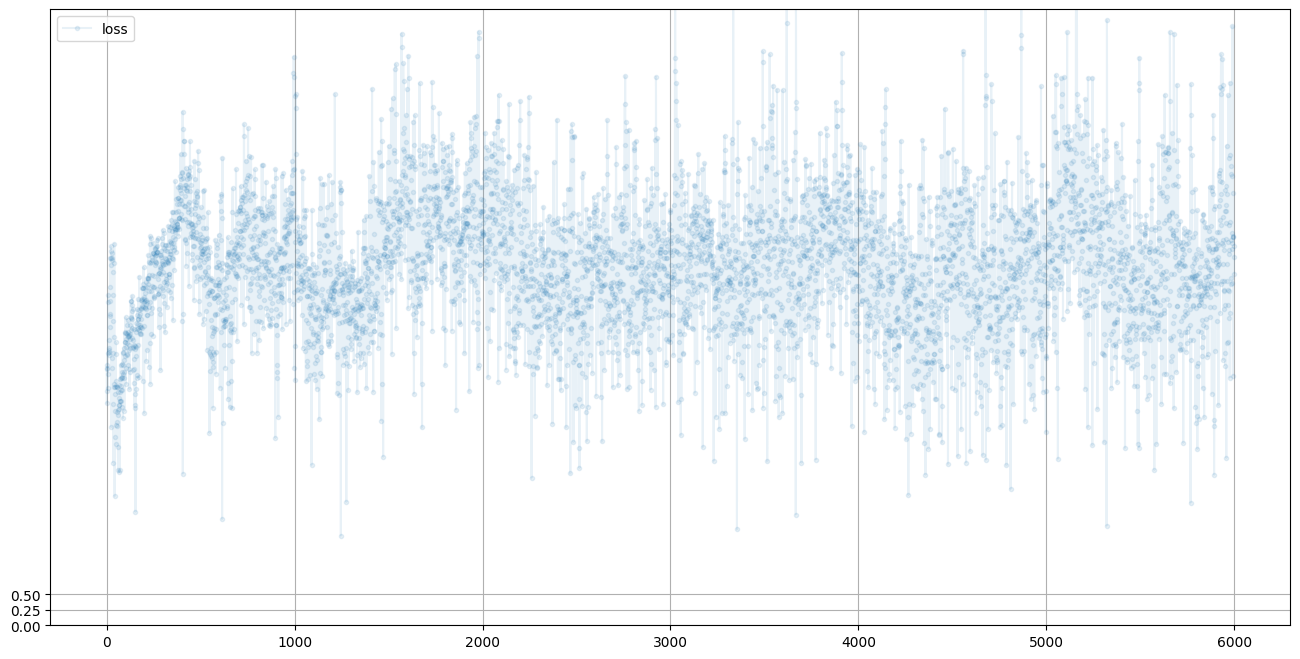

In [ ]:
df = pandas.DataFrame(G.progress, columns=['loss'])
df.plot(ylim=(0,10.0), figsize=(16,8), alpha=0.1,
        marker='.', grid=True, yticks=(0,0.25,0.5))

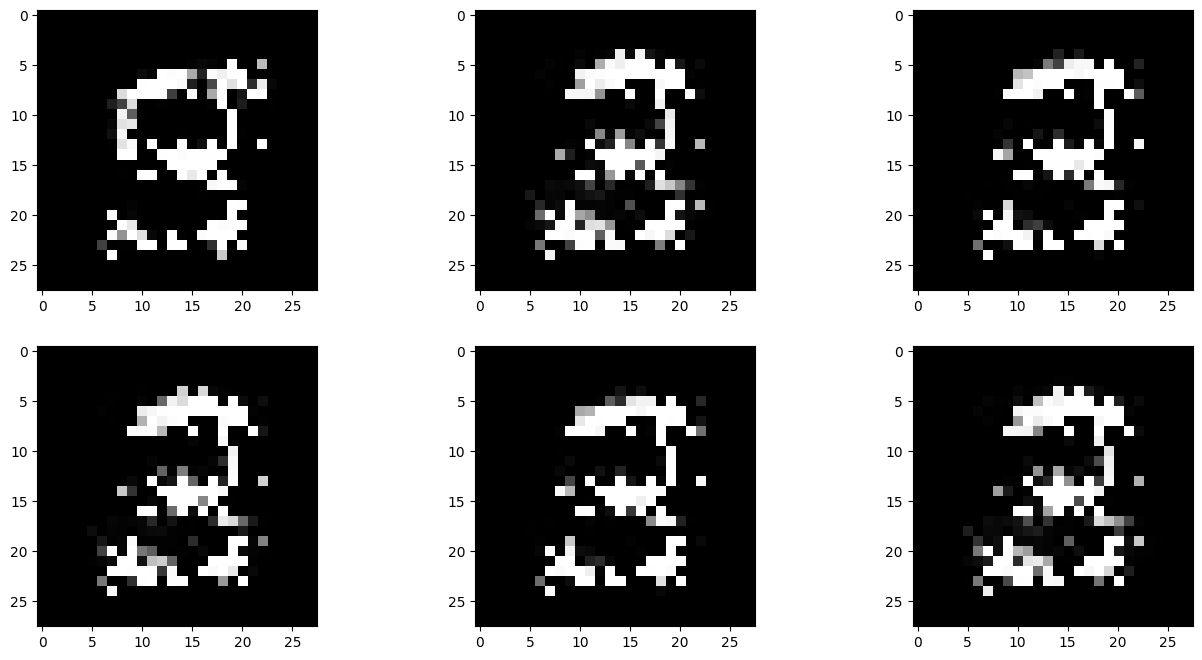

In [20]:
# 在3列2行的网格中生成图像
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='gray')
        pass
    pass

In [ ]:
# 增加生成器的输入节点至100

# 判别器的构造

class Discriminator(nn.Module):

    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # 创建损失函数
        # self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss()

        # 创建优化器，使用随机梯度下降
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.forward(inputs)

        # 计算损失值
        loss = self.loss_function(outputs, targets)

        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))

# 构建生成器

class Generator(nn.Module):

    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(100,200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200,784),
            nn.Sigmoid()
        )

        # 创建优化器，使用随机梯度下降
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入判别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)
        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5,1.0,5.0))


In [13]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data
# 创建鉴别器和生成器
D = Discriminator()
G = Generator()
# 训练鉴别器和生成器
for label, image_data_tensor, target_tensor in mnist_dataset:
    # 使用真实数据训练鉴别器
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # 用生成样本训练鉴别器
    # 使用detach()以避免计算生成器G中的梯度
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    # 训练生成器
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

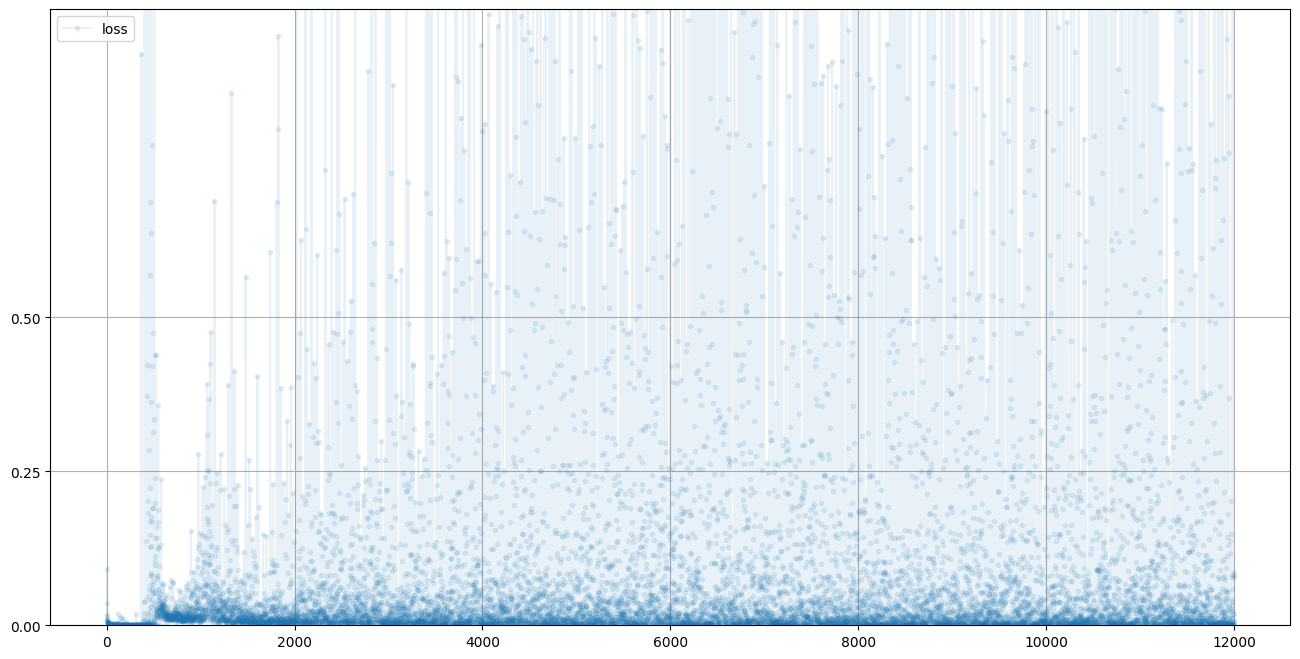

In [14]:
D.plot_progress()

损失值迅速下降到接近于0，并一直保持在很低的位置。训练期间，损失值偶尔发生跳跃。这说明生成器和鉴别器之间仍然没有取得平衡。

<Axes: >

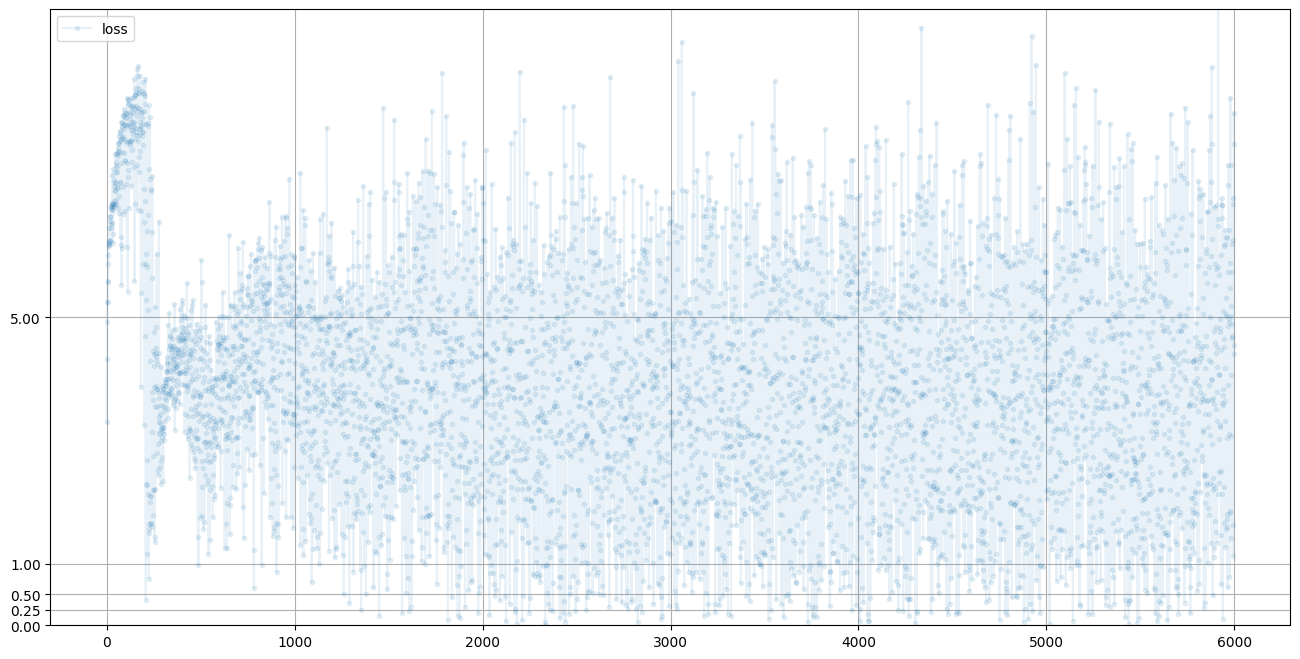

In [17]:
df = pandas.DataFrame(G.progress, columns=['loss'])
df.plot(ylim=(0,10.0), figsize=(16,8), alpha=0.1,
        marker='.', grid=True, yticks=(0,0.25,0.5,1.0,5.0))

损失值先是上升，表示在训练早期生成器落后于鉴别器。之后，损失值下降并保持在3左右。记住，与MSELoss不同，BCELoss没有1.0的上限。

这些损失图看起来有些令人失望，因为损失值的范围更广了。不过，它们仍然好于改良之前的损失图。在之前的图中，鉴别器的损失值在下降时没有太大的波动，生成器的损失值在上升时同样非常工整。这些现象看似令人满意，但不断增加的生成器损失值并不是我们希望的。理想的情况应该是，生成器的损失值只在一个有限的平均值附近变化。

一个很好的问题是，如果我们达到了平衡，BCELoss应该是什么？如果我们运行简单的1010 GAN并达到平衡，由于使用BCELoss，我们会看到生成器和鉴别器的损失值都接近于0.69。读者可以自己试试。对一个完全不确定的分类器使用二元交叉熵，根据数学定义可以计算出，理想的损失值为ln 2或0.693。

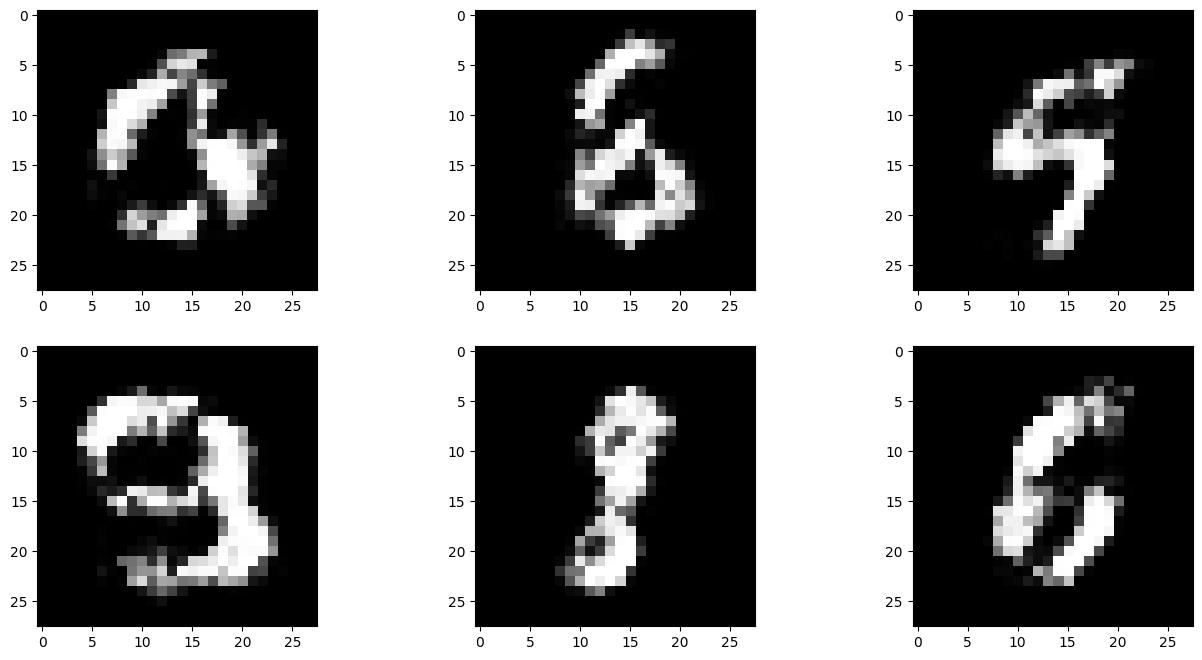

In [16]:
# 在3列2行的网格中生成图像
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='gray')
        pass
    pass

In [18]:
# 创建鉴别器和生成器
D = Discriminator()
G = Generator()
# 训练鉴别器和生成器

epochs = 8
for i in range(epochs):
    print('training epoch', i+1, 'of', epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        # 使用真实数据训练鉴别器
        D.train(image_data_tensor, torch.FloatTensor([1.0]))
        # 用生成样本训练鉴别器
        # 使用detach()以避免计算生成器G中的梯度
        D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
        # 训练生成器
        G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))


training epoch 1 of 8
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

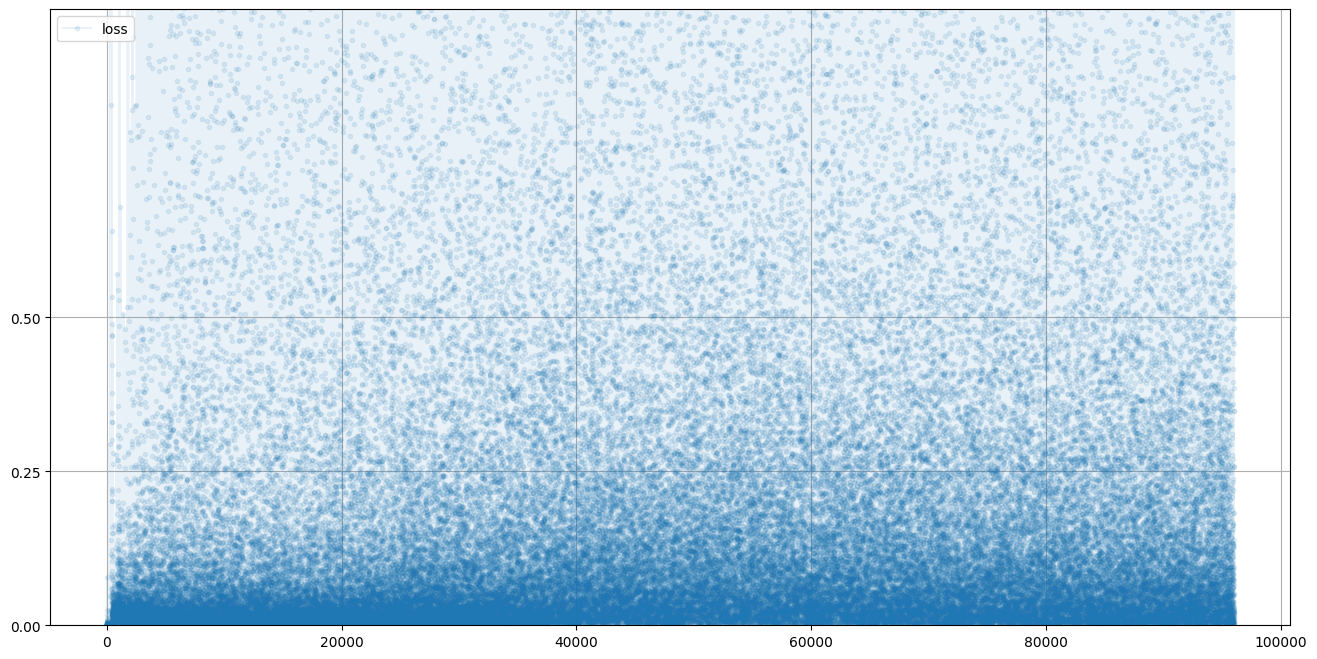

In [19]:
D.plot_progress()

<Axes: >

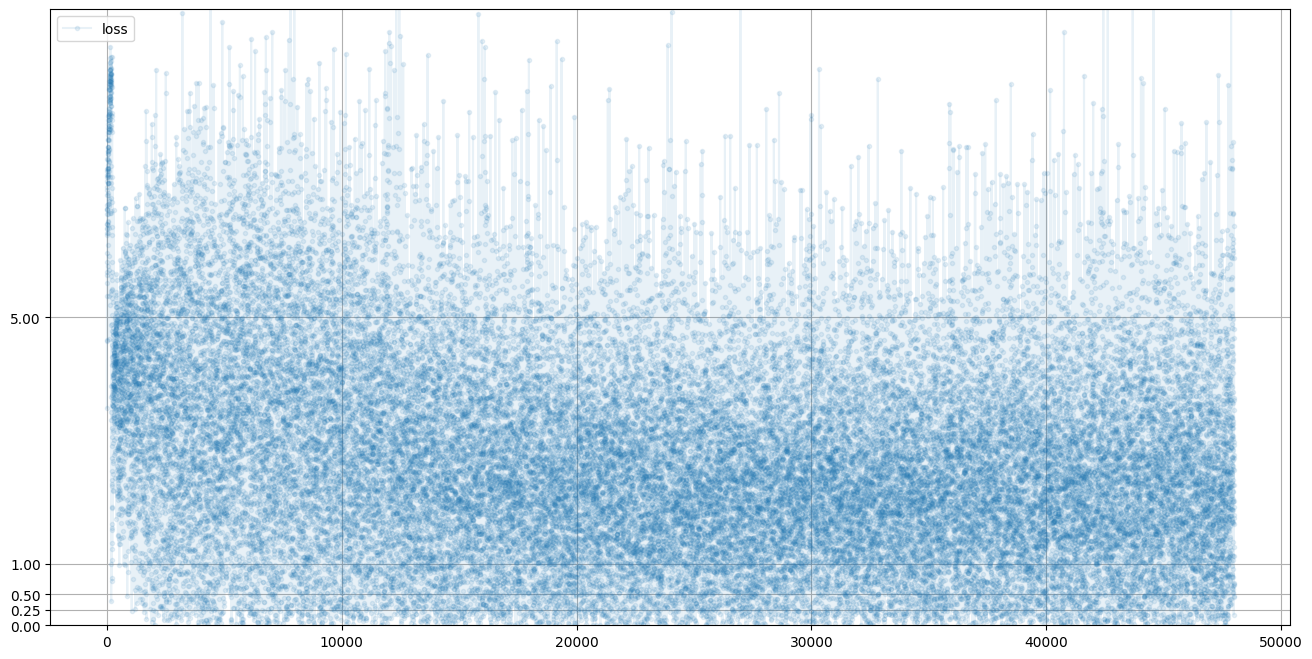

In [21]:
df = pandas.DataFrame(G.progress, columns=['loss'])
df.plot(ylim=(0,10), figsize=(16,8), alpha=0.1,
        marker='.', grid=True, yticks=(0,0.25,0.5,1.0,5.0))

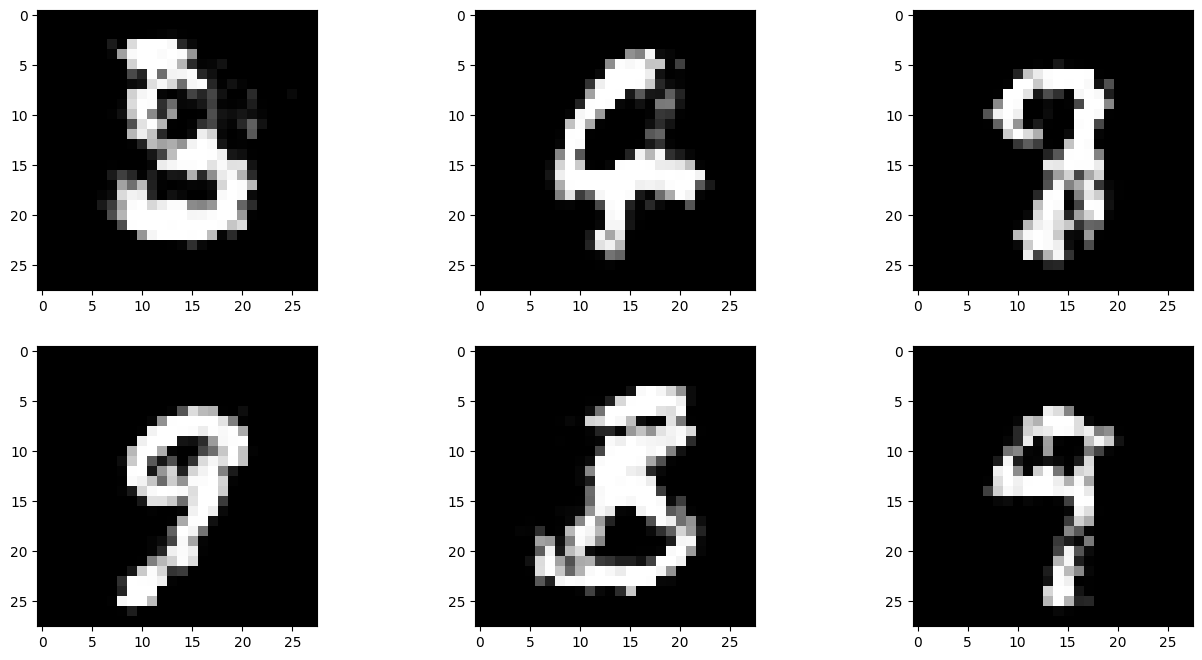

In [22]:
# 在3列2行的网格中生成图像
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='gray')
        pass
    pass